In [1]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import json
import numpy as np
import datetime as dt
import glob
import os
import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid',{'grid.linestyle': '-', 'grid.color': '0.9', 'axes.edgecolor': '0.9'})

# plotting on world maps
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

# finding the state based on geotags
from geopy.geocoders import Nominatim

# the Geonamescache library contains information
# about continents, cities and US states
import geonamescache

# regular expressions for matching tweet
# locations to a dictionary of locations
import re

# for sorting dictionaries
import operator

# scraping population information from wikipedia
from bs4 import BeautifulSoup
import requests

# figure out the time zone strangeness
import pytz
from dateutil import tz

### area for tweet scraping

In [2]:
# from twitter_functions import *
# api = load_api()
# tweets, tweet_id = tweet_search(api, 'the', 1, 1, 1, '')
# try:
#     print(tweets[0].created_at)
# except:
#     print('error:')
#     print(sys.exc_info()[0])

The time of the most recent tweet was 6 hours ahead of me.  This means the tweets are being returned in coordinated universal time (UTC).

### data analysis tests

In [3]:
#with open('#makedonalddrumpfagain_2016-02-29.json','r') as f:
#    count = 0
#    RTcount = 0
#    tweet_dates = []
#    for line in f.readlines():
#        count += 1
#        #tweet_date = json.loads(line)['created_at']
#        tweet = json.loads(line)
#        date =  dt.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')#.replace(tzinfo=pytz.UTC)
#        tweet_dates.append(date)

#plt.hist([t.hour + t.minute/60. for t in tweet_dates], bins = 24*60/15)

#        if "RT" in json.loads(line)['text']:
#            RTcount += 1
        #print(json.loads(line)['created_at'])
        #print(json.loads(line)['id'])
#print(RTcount)
#print(count)
#print(json.loads(line)['created_at'])

### Read our tweets into a dataframe

In [4]:
# use glob to search through all dates with specific hashtag
# then read the files and load the cumulitive result into a
# dictionary to return
def merge_tweets(file_root, skip=100):
    ''' Function that compiles tweets from multiple files
        into a single list.  This may take a while.'''
    print(list(glob.iglob(file_root+'*')))
    tweet_files = list(glob.iglob(file_root+'*'))
    tweets = []
    for file in tweet_files:
        with open(file, 'r') as f:
            for i, line in enumerate(f.readlines()):
                    if i%skip == 0:
                        tweets.append(json.loads(line))
        print('finished importing file:', file)
    return tweets

In [5]:
drumpf_tweets = merge_tweets(file_root='drumpf_tweets\#make', skip=100)
#drumpf_tweets = merge_tweets(file_root='#makedonalddrumpfagain_2016-02-29')

['drumpf_tweets\\#makedonalddrumpfagain_2016-02-29.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-01.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-02.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-03.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-04.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-05.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-06.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-07.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-08.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-09.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-10.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-11.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-12.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-13.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-14.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-15.json', 'drumpf_tweets\\#makedonalddrumpfagain_2016-03-16.json', 'drumpf_tweets\\#makedonalddru

In [6]:
print(len(drumpf_tweets))
drumpf_tweets[0].keys()

5509


dict_keys(['in_reply_to_status_id_str', 'geo', 'lang', 'entities', 'id', 'created_at', 'in_reply_to_user_id', 'place', 'contributors', 'source', 'truncated', 'retweeted', 'favorite_count', 'is_quote_status', 'favorited', 'in_reply_to_screen_name', 'coordinates', 'retweet_count', 'metadata', 'in_reply_to_user_id_str', 'possibly_sensitive', 'retweeted_status', 'text', 'in_reply_to_status_id', 'id_str', 'user'])

### Populate a dataframe with desired information

In [7]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
    
    df['user'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))

    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    
    df['created_at'] = list(map(lambda tweet: tweet['created_at'], tweets))
    
    df['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
    
    df['country_code'] = list(map(lambda tweet: tweet['place']['country_code']
                                  if tweet['place'] != None else '', tweets))
    
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))

    return df

In [8]:
drumpf_dataframe = populate_tweet_df(drumpf_tweets)
df = drumpf_dataframe
df.tail()

,user,text,created_at,location,country_code,long,latt
5504,MarkDavidAnder9,"RT @Reid_CO: ""Donald Trump Made Up Stuff 71 Ti...",Thu Mar 31 04:45:38 +0000 2016,,,NaN,NaN
5505,ChloePott,RT @ChloePOTU: Maybe if enough people report @...,Thu Mar 31 03:04:04 +0000 2016,Paris & Chicago,,NaN,NaN
5506,Frank_Hurlemann,This maniac in North-Korea?\nThis is so presid...,Thu Mar 31 02:05:30 +0000 2016,"Baltic Sea, Germany",,NaN,NaN
5507,AprilCRich,"My head exploded!!! Well, figuratively anyway....",Thu Mar 31 01:05:44 +0000 2016,,,NaN,NaN
5508,LPiper64,RT @TheoloGOP: Abortion is not a crime. Wanna ...,Thu Mar 31 00:29:26 +0000 2016,,,NaN,NaN


# run all above to initialize drumpf_dataframe

### location based on longitude latitude

In [9]:
def get_states(longs, latts):
    ''' Input two 1D lists of floats/ints '''
    # a list of states
    states = []
    # use a coordinate tool from the geopy library
    geolocator = Nominatim()
    for lon, lat in zip(longs, latts):
        try:
            # get the state name
            location = geolocator.reverse(str(lat)+', '+str(lon))
            state = location.raw['address']['state']
        except:
            # return empty string
            state = ''
        states.append(state)
    return states

In [10]:
# df = drumpf_dataframe.loc[(drumpf_dataframe.location != '')]
# longs = list(df.loc[(df.long != 'NaN')].long)
# latts = list(df.loc[df.latt != 'NaN'].latt)
# print(longs)
# print(latts)

# states = get_states(longs, latts)
# print(states)

### make a dictionary of us states and cities

In [11]:
# get a dictionary of states: 's'
gc = geonamescache.GeonamesCache()
s = gc.get_us_states()

# link state ID's e.g., TX, AB ...
# to states e.g., Texas, Alabama ...
stateID_to_state = {}
# define a list of states not to
# include as lower case due to chance
# of confusion with other words
no_lower_case_conversion = [
    'HI', 'IN', 'ME', 'MT', 'OH', 'OK', 'OR', 'DE']
for key in s.keys():
    state = s[key]['name']
    stateID_to_state[key] = state
    if key not in no_lower_case_conversion:
        stateID_to_state[key.lower()] = state

# link state name to itself
state_to_state = {}
for key in s.keys():
    state = s[key]['name']
    state_to_state[state] = state

In [12]:
# get a dictionary of cities: 'c'
gc = geonamescache.GeonamesCache()
c = gc.get_cities()

# extract the US city names and coordinates
US_cities = [c[key]['name'] for key in list(c.keys())
          if c[key]['countrycode'] == 'US']
US_longs = [c[key]['longitude'] for key in list(c.keys())
         if c[key]['countrycode'] == 'US']
US_latts = [c[key]['latitude'] for key in list(c.keys())
        if c[key]['countrycode'] == 'US']

In [13]:
# find the states of each city
# WARNING: this takes a while
if False:
    US_states = get_states(US_longs, US_latts)

In [14]:
# print the data to a file for quick
# reading next time

filename = 'US_city_to_state.dat'
if not os.path.isfile(filename):
    with open(filename, 'w') as f:
        for city, state in zip(US_cities, US_states):
            try:
                f.write(city + ',' + state + ' \n')
            except:
                print('Cannot write city named:', city,
                      'in state', state)
            
US_cities, US_states = [], []
with open(filename, 'r') as f:
    for line in f.readlines():
        line = line.split(',')
        US_cities.append(line[0])
        US_states.append(line[1][:-2])

In [15]:
# create a dictionary linking cities
# as keys with their states

city_to_state = {}
for city, state in zip(US_cities, US_states):
    if state:
        city_to_state[city] = state

# remove the cities we don't want
skip = ['Dublin', 'Hamilton', 'Oxford', 'Ontario',
        'Vancouver', 'Ottawa', 'Kingston', 'Jamaica',
        'Columbia', 'Geneva', 'Melbourne', 'Durango',
        'Elgin', 'Moscow', 'Sudbury', 'Holland',
        'Belleville', 'Dublin', 'Amsterdam']
for key in skip:
    if key in city_to_state:
        del city_to_state[key]

### search through the dataframe and add a column for the actual location

In [16]:
def find_word(w):
    return re.compile(r'\b({0})\b'.format(w),
                      flags=re.IGNORECASE)

def find_word_case(w):
    return re.compile(r'\b({0})\b'.format(w))

def find_state_name(tweet_location):
    
    # binary type output file
    f = open('find_state_name_drumpf.dat', 'wb')
    
    # look for the state ID in
    # the location string
    for key in stateID_to_state.keys():
        # search for the case sensitive state ID
        # to avoid matching things like
        # location = 'here or there' = Oregon
        if find_word_case(key).search(tweet_location):
            f.write((str(tweet_location) + ' : ' + str(key) + ' -> ' + str(stateID_to_state[key]) + '\n').encode('utf-8'))
            print(tweet_location, ':', key, '->', stateID_to_state[key])
            return stateID_to_state[key]
    
    # otherwise look for states
    for key in state_to_state.keys():
        if find_word(key).search(tweet_location):
            f.write((str(tweet_location) + ' : ' + str(key) + ' -> ' + str(state_to_state[key]) + '\n').encode('utf-8'))
            print(tweet_location, ':', key, '->', state_to_state[key])
            return state_to_state[key]
        
    # otherwise look for cities
    for key in city_to_state.keys():
        if find_word(key).search(tweet_location):
            f.write((str(tweet_location) + ' : ' + str(key) + ' -> ' + str(city_to_state[key]) + '\n').encode('utf-8'))
            print(tweet_location, ':', key, '->', city_to_state[key])
            return city_to_state[key]
        
    # otherwise return empty string
    return ''

In [17]:
# disable warning
# default='warn'
pd.options.mode.chained_assignment = None

In [18]:
if False:
    filename = 'drumpf_location_to_state.dat'
    states = []
    for i in df.index:
        name = find_state_name(df.location[i])
    df['State'] = states
   
    # finally, look up the long/latt
    # coordinates for tweets where the
    # state was not found
    for i in df.index:
        if df.long[i] != 'NaN' and df.latt[i] != 'NaN':
            if df.State[i] == '':
                state = get_states([df.long[i]],[df.latt[i]])
                df.State[i] = state[0]
                print('Found state:', state[0], 'for location =', df.location[i])
                
    ''' Output locations (including empty strings) to a file
    that can be read instead of the lengthy matching procedure
    above. '''
    with open(filename, 'w') as f:
        for i in df.index:
            f.write(str(df.loc[i, 'State']) + '\n')

#### quick load

In [19]:
filename = 'drumpf_location_to_state.dat'
    
if True and 'State' not in df.columns:
    ''' Read in state names from the file. '''
    states = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            states.append(line.rstrip())
    print(len(df.index))
    print(len(states))
    df['State'] = states

df.tail()

549347
549347


,user,text,created_at,location,country_code,long,latt,State
549342,lwdgrfx,#NeverTrump #MakeDonaldDrumpfAgain https://t....,Thu Mar 31 00:02:24 +0000 2016,"Jackson,MS",,NaN,NaN,Mississippi
549343,scoobydoo22b,@simonblackwell His thinking is getting more I...,Thu Mar 31 00:01:48 +0000 2016,,,NaN,NaN,
549344,lwdgrfx,#NeverTrump #MakeDonaldDrumpfAgain #SlickDonny...,Thu Mar 31 00:01:33 +0000 2016,"Jackson,MS",,NaN,NaN,Mississippi
549345,Channing1445,#MakeDonaldDrumpfAgain https://t.co/vJJvyKIRly,Thu Mar 31 00:00:36 +0000 2016,"North Queen Anne, Seattle",US,NaN,NaN,Washington
549346,MeaganRoseKT,You really want @realDonaldTrump as your presi...,Thu Mar 31 00:00:25 +0000 2016,,,NaN,NaN,


In [20]:
count = 0
for i in states:
    if i=='':
        count += 1
print((len(states)-count)/len(df.index)*100,
      '% of tweet locations found')
print(len(states)-count)

38.20645238801705 % of tweet locations found
209886


Let's remove duplicate users for the following analysis.  We'll re-create the dataframe later when plotting the histogram and include all tweets.

In [21]:
df2 = df.drop_duplicates(['user'])

In [22]:
print(len(df2))
df2.tail()

280601


,user,text,created_at,location,country_code,long,latt,State
549309,EYE_KILL_IT,RT @TheoloGOP: Basing civil law on religious s...,Thu Mar 31 00:13:55 +0000 2016,TruthSeeker,,NaN,NaN,
549314,simmbun,RT @TheoloGOP: Abortion is not a crime. Wanna ...,Thu Mar 31 00:13:19 +0000 2016,,,NaN,NaN,
549326,artlessventure,"RT @DivineNoodles: ""Your feeble skills are no ...",Thu Mar 31 00:07:39 +0000 2016,"Tübingen, Baden-Württemberg",,NaN,NaN,
549341,partsman1959,RT @cingroomer: #MakeDonaldDrumpfAgain https:/...,Thu Mar 31 00:02:40 +0000 2016,,,NaN,NaN,
549346,MeaganRoseKT,You really want @realDonaldTrump as your presi...,Thu Mar 31 00:00:25 +0000 2016,,,NaN,NaN,


In [100]:
count = 0
j = 0
for i in df2.State:
    j += 1
    if i=='':
        count += 1
#    if j == 15:
#        break
print((len(df2.State)-count)/len(df2.State)*100,
      '% of tweet locations found')
print(len(df2.State)-count)

36.990602314318195 % of tweet locations found
103796


### make color coded map (blue/white) of USA states

#### Mine population data from Wikipedia!

In [65]:
''' Get US state populations (as of 2014) to weight tweet counts '''
url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population'
req = requests.get(url)
page = req.text
soup = BeautifulSoup(page, 'html.parser')
table = soup.find_all('table')[1]
rows = [row for row in table.find_all('tr')]

US_state_populations = {}
US_state_electoral_votes = {}
for row in rows:
    try:
        state = row.find_all('td')[1].find_all('a')[0].get_text()
        US_state_populations[state] = int(row.find_all('td')[2].get_text().replace(',',''))
        US_state_electoral_votes[state] = int(row.find_all('td')[4].get_text().replace(',',''))
    except:
        pass
print(US_state_populations)
print(US_state_electoral_votes)

{'Missouri': 6063589, 'Wyoming': 584153, 'New Hampshire': 1326813, 'Illinois': 12880580, 'Utah': 2942902, 'Maryland': 5976407, 'Nevada': 2839099, 'Tennessee': 6549352, 'Nebraska': 1881503, 'New Jersey': 8938175, 'Rhode Island': 1055173, 'Wisconsin': 5757564, 'Massachusetts': 6745408, 'Alaska': 737732, 'Maine': 1330089, 'North Carolina': 9943964, 'New Mexico': 2085572, 'Vermont': 626011, 'Georgia': 10097343, 'Iowa': 3107126, 'Virginia': 8326289, 'Texas': 26956958, 'California': 38802500, 'Kentucky': 4413457, 'Arizona': 6731484, 'Hawaii': 1419561, 'South Carolina': 4832482, 'Connecticut': 3596677, 'Montana': 1023579, 'Ohio': 11594163, 'Arkansas': 2994079, 'South Dakota': 853175, 'Idaho': 1634464, 'Indiana': 6596855, 'Louisiana': 4649676, 'Delaware': 935614, 'Colorado': 5355856, 'Minnesota': 5457173, 'Oklahoma': 3878051, 'Florida': 19893297, 'North Dakota': 739482, 'New York': 19746227, 'Kansas': 2904021, 'Pennsylvania': 12787209, 'Washington': 7061530, 'Oregon': 3970239, 'Alabama': 48493

In [66]:
# get a list of states: 's'
gc = geonamescache.GeonamesCache()
s = gc.get_us_states()
states = [s[key]['name'] for key in s.keys()]

counts_per_state = {}
for key in states:
    counts_per_state[key] = 0

for location in df2.State:
    for key in states:
        if key in location:
            counts_per_state[key] += 1

print(counts_per_state)

{'Missouri': 1417, 'New Hampshire': 820, 'Louisiana': 1502, 'Utah': 1021, 'Arizona': 1761, 'Nevada': 904, 'Tennessee': 1792, 'Nebraska': 703, 'New Jersey': 2603, 'Rhode Island': 568, 'Wisconsin': 1415, 'Hawaii': 309, 'Alaska': 234, 'Pennsylvania': 3645, 'Maine': 381, 'Mississippi': 309, 'Wyoming': 113, 'Vermont': 284, 'Ohio': 3123, 'Georgia': 2523, 'Iowa': 951, 'Massachusetts': 3779, 'Texas': 7139, 'California': 15628, 'Kentucky': 1099, 'Maryland': 1570, 'District of Columbia': 1878, 'New Mexico': 392, 'Connecticut': 911, 'Montana': 221, 'Washington': 3792, 'South Carolina': 978, 'Arkansas': 525, 'South Dakota': 201, 'Idaho': 380, 'Indiana': 1630, 'Illinois': 4966, 'Colorado': 2433, 'Virginia': 2200, 'Minnesota': 2357, 'Oklahoma': 835, 'North Dakota': 201, 'New York': 9393, 'West Virginia': 371, 'North Carolina': 2290, 'Alabama': 920, 'Oregon': 2129, 'Florida': 5443, 'Michigan': 2942, 'Kansas': 937, 'Delaware': 249}


In [67]:
# get ordered list
ordered_list = [(key, value) for key, value in zip(counts_per_state.keys(),counts_per_state.values())]
sorted(ordered_list, key=operator.itemgetter(1))

[('Wyoming', 113),
 ('South Dakota', 201),
 ('North Dakota', 201),
 ('Montana', 221),
 ('Alaska', 234),
 ('Delaware', 249),
 ('Vermont', 284),
 ('Hawaii', 309),
 ('Mississippi', 309),
 ('West Virginia', 371),
 ('Idaho', 380),
 ('Maine', 381),
 ('New Mexico', 392),
 ('Arkansas', 525),
 ('Rhode Island', 568),
 ('Nebraska', 703),
 ('New Hampshire', 820),
 ('Oklahoma', 835),
 ('Nevada', 904),
 ('Connecticut', 911),
 ('Alabama', 920),
 ('Kansas', 937),
 ('Iowa', 951),
 ('South Carolina', 978),
 ('Utah', 1021),
 ('Kentucky', 1099),
 ('Wisconsin', 1415),
 ('Missouri', 1417),
 ('Louisiana', 1502),
 ('Maryland', 1570),
 ('Indiana', 1630),
 ('Arizona', 1761),
 ('Tennessee', 1792),
 ('District of Columbia', 1878),
 ('Oregon', 2129),
 ('Virginia', 2200),
 ('North Carolina', 2290),
 ('Minnesota', 2357),
 ('Colorado', 2433),
 ('Georgia', 2523),
 ('New Jersey', 2603),
 ('Michigan', 2942),
 ('Ohio', 3123),
 ('Pennsylvania', 3645),
 ('Massachusetts', 3779),
 ('Washington', 3792),
 ('Illinois', 4966),
 

In [68]:
counts_per_state.keys()
s.keys()

dict_keys(['NV', 'WV', 'KS', 'OK', 'NH', 'MT', 'MD', 'OH', 'WA', 'OR', 'RI', 'ID', 'WI', 'MI', 'CO', 'NY', 'NM', 'SD', 'ND', 'DE', 'MO', 'KY', 'MA', 'DC', 'AL', 'ME', 'HI', 'MS', 'NE', 'VT', 'IN', 'IL', 'NC', 'WY', 'UT', 'FL', 'NJ', 'CA', 'CT', 'LA', 'VA', 'GA', 'AZ', 'TN', 'IA', 'MN', 'AR', 'TX', 'PA', 'AK', 'SC'])

In [361]:
''' Let's sort counts_per_state by longitude! '''
# using Geopy again
geolocator = Nominatim()
longs = {}
for key in counts_per_state.keys():
    for stateID in s.keys():
        name = s[stateID]['name']
        if name == key:
            if name == 'Washington':
                longs[key] = -120.0
            else:
                try:
                    g = geolocator.geocode(name)
                    longs[key] = g.longitude
                except:
                    print('Cannot find geocode for', name)
        
sorted_longs = sorted(longs.items(), key=operator.itemgetter(1))
print(sorted_longs)

[('Hawaii', -157.9752029), ('Alaska', -149.6809089), ('Oregon', -120.7372569), ('Washington', -120.0), ('California', -118.7559973), ('Nevada', -116.8537226), ('Idaho', -114.015407), ('Arizona', -111.7632754), ('Utah', -111.7143583), ('Montana', -109.6387578), ('Wyoming', -107.5685347), ('New Mexico', -105.9930069), ('Colorado', -105.6077166), ('North Dakota', -100.5407369), ('South Dakota', -100.3487609), ('Nebraska', -99.5873815), ('Texas', -99.5120985), ('Kansas', -98.5821871), ('Oklahoma', -97.2684062), ('Minnesota', -94.6113287), ('Iowa', -93.3122704), ('Missouri', -92.5617874), ('Arkansas', -92.4479107), ('Louisiana', -92.0071259), ('Mississippi', -89.7348496), ('Wisconsin', -89.6884636), ('Illinois', -89.4339808), ('Alabama', -86.8295336), ('Tennessee', -86.282008), ('Indiana', -86.1746932), ('Kentucky', -85.155141), ('Michigan', -84.6824345), ('Georgia', -83.1137365), ('Ohio', -82.6881394), ('Florida', -81.4639834), ('West Virginia', -80.8408414), ('South Carolina', -80.4363742

In [70]:
''' We define 3 variable y1, y2, and y3 to keep track of
    the counts per state with different weights and scales.
    
    The labels variable defined here is maintined for all
    plot below (up to the frequency histograms)'''

sorted_counts_per_state = []
labels = []
for a, b in sorted_longs:
    sorted_counts_per_state.append(counts_per_state[a])
    labels.append(a)

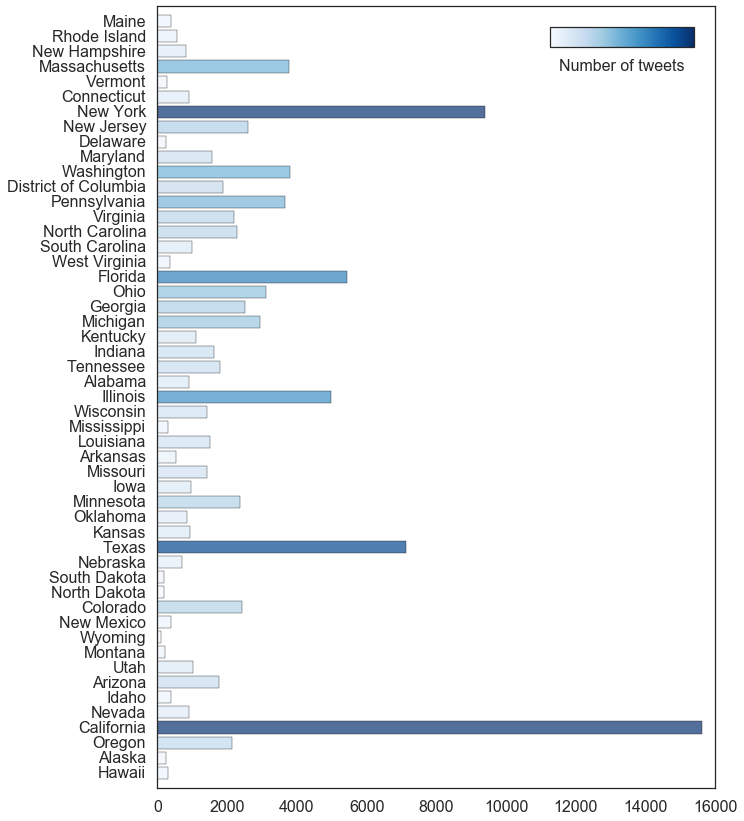

In [71]:
''' fake up a plot to define our color bar '''
x = np.linspace(-1.2,1.2,100)
y = x
c = x
fig, ax = plt.subplots()
im = ax.scatter(x, y, c=c, cmap=plt.cm.Blues)
# Add a colorbar
fig.colorbar(im, ax=ax)
plt.close(fig)

sns.set_style('white')

fig = plt.figure(figsize=(10,14))

y = sorted_counts_per_state
x = np.arange(0,len(y))

c = sns.color_palette('Blues', len(y))

c_list = []
for i in range(len(y)):
    index = int(y[i]/max(y)*(len(y)*2))
    if index >= (len(y)-1):
        index = (len(y)-1)
    c_list.append(c[index])

plt.barh(x, y, align='center', color=c_list, alpha=0.7, label='Number of tweets')
plt.yticks(x, labels)
plt.ylim(-1, len(y))

#plt.legend(frameon=True)

# plot the color bar
cbaxes = fig.add_axes([0.67, 0.86, 0.2, 0.02]) 
cbar = plt.colorbar(im, ax=ax, ticks=[0], cax=cbaxes, orientation='horizontal')  
cbar.ax.set_xticklabels(['Number of tweets'])  # vertically oriented colorbar

plt.savefig('tweets_by_state.png', bbox_inches='tight', dpi=144)

plt.show()

In [362]:
''' Get the number of tweets per electoral vote and
    scaled (plus unscaled) number of tweets per capita. '''

sorted_counts_per_state = []
labels = []
for a, b in sorted_longs:
    sorted_counts_per_state.append(counts_per_state[a])
    labels.append(a)

y1 = []
i_remove = -1
for i, state in enumerate(labels):
    try:
        y1.append(sorted_counts_per_state[i]/US_state_populations[state])
        #print(sorted_counts_per_state[i]/US_state_populations[state])
        #print('state  =', state)
        #print('counts =', sorted_counts_per_state[i])
        #print('pop    =', US_state_populations[state])
        #print('ratio  =', sorted_counts_per_state[i]/US_state_populations[state]*1000000)
        #print('')
        # get ordered list
    except:
        #print('!!!!!!!!!!!!!!!!!!!!!!!')
        print('Skipping', state, 'and removing from labels and count list')
        i_remove = i
if i_remove >= 0:
    del labels[i_remove]
    del sorted_counts_per_state[i_remove]
        
y2 = []
for i, state in enumerate(labels):
    try:
        y2.append(sorted_counts_per_state[i]/US_state_electoral_votes[state])
        #print(sorted_counts_per_state[i]/US_state_electoral_votes[state])
    except:
        print('Something is wrong with y2')
        
''' Now scale the tweets per population up to be on the order of
    tweets per electoral vote.'''
y3 = []
scale = max(y2)/max(y1)
for i, state in enumerate(labels):
    try:
        y3.append(sorted_counts_per_state[i]/US_state_populations[state]*scale)
        #print(sorted_counts_per_state[i]/US_state_populations[state]/max(y1))
    except:
        print('Something is wrong with y2')
        
y0 = []
for i, state in enumerate(labels):
    y0.append(sorted_counts_per_state[i])
    
print(len(y1), len(y2), len(y3), len(y0))
print('')
print(list(zip(y0,labels)))
print('')
print(max(y1))
print(max(y2))
print(max(y3))
print(labels)

Skipping District of Columbia and removing from labels and count list
50 50 50 50

[(309, 'Hawaii'), (234, 'Alaska'), (2129, 'Oregon'), (3792, 'Washington'), (15628, 'California'), (904, 'Nevada'), (380, 'Idaho'), (1761, 'Arizona'), (1021, 'Utah'), (221, 'Montana'), (113, 'Wyoming'), (392, 'New Mexico'), (2433, 'Colorado'), (201, 'North Dakota'), (201, 'South Dakota'), (703, 'Nebraska'), (7139, 'Texas'), (937, 'Kansas'), (835, 'Oklahoma'), (2357, 'Minnesota'), (951, 'Iowa'), (1417, 'Missouri'), (525, 'Arkansas'), (1502, 'Louisiana'), (309, 'Mississippi'), (1415, 'Wisconsin'), (4966, 'Illinois'), (920, 'Alabama'), (1792, 'Tennessee'), (1630, 'Indiana'), (1099, 'Kentucky'), (2942, 'Michigan'), (2523, 'Georgia'), (3123, 'Ohio'), (5443, 'Florida'), (371, 'West Virginia'), (978, 'South Carolina'), (2290, 'North Carolina'), (2200, 'Virginia'), (3645, 'Pennsylvania'), (1570, 'Maryland'), (249, 'Delaware'), (2603, 'New Jersey'), (9393, 'New York'), (911, 'Connecticut'), (284, 'Vermont'), (3779

50 50 50 50


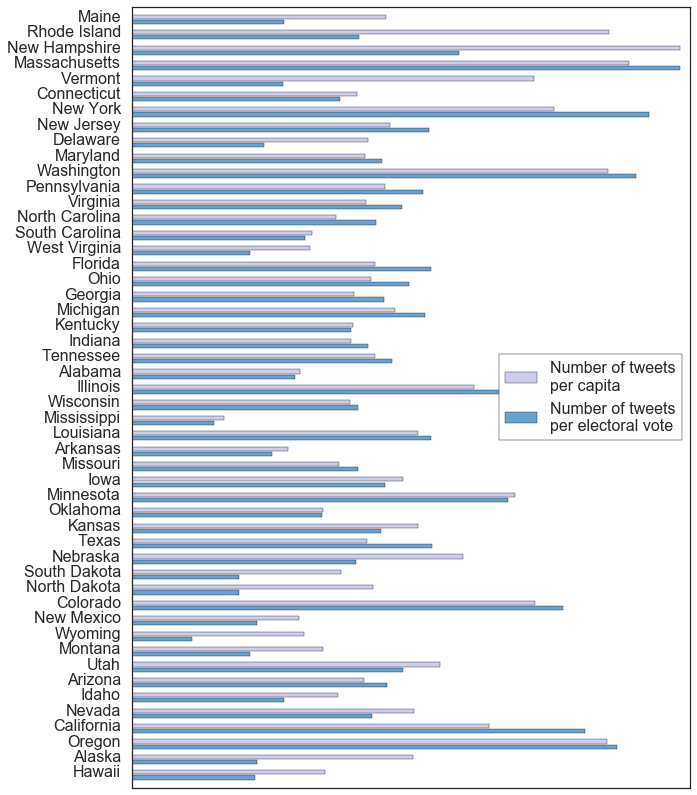

In [73]:
fig = plt.figure(figsize=(10,14))
sns.set_style('white')

mid_spacing = 1.5
x3 = np.arange(0,len(y3)*mid_spacing, mid_spacing)
x2 = [x+0.5 for x in x3]

print(len(x3), len(x2), len(y3), len(y2))

c = sns.color_palette('Blues')
c1 = sns.light_palette('navy')

plt.barh(x2, y3, align='center', color=c1[1], alpha=0.7, height=0.4,
         label='Number of tweets\nper capita')
plt.barh(x3, y2, align='center', color=c[4], alpha=0.7, height=0.4,
         label='Number of tweets\nper electoral vote')

plt.yticks(x2, labels)
plt.ylim(-1, len(y3)*mid_spacing)

plt.xticks([])
#plt.xlim(0,5)

#plt.title('Locations of users who tweeted the hashtag #makedonalddrumpfagain \ncollected from March 29th to April 20th, 2016',
#          y=1.01, fontsize=17, alpha=1)

#plt.legend(frameon=True, loc=(0.62, 0.71))
plt.legend(frameon=True, loc='best')

plt.show()

50 50 50 50


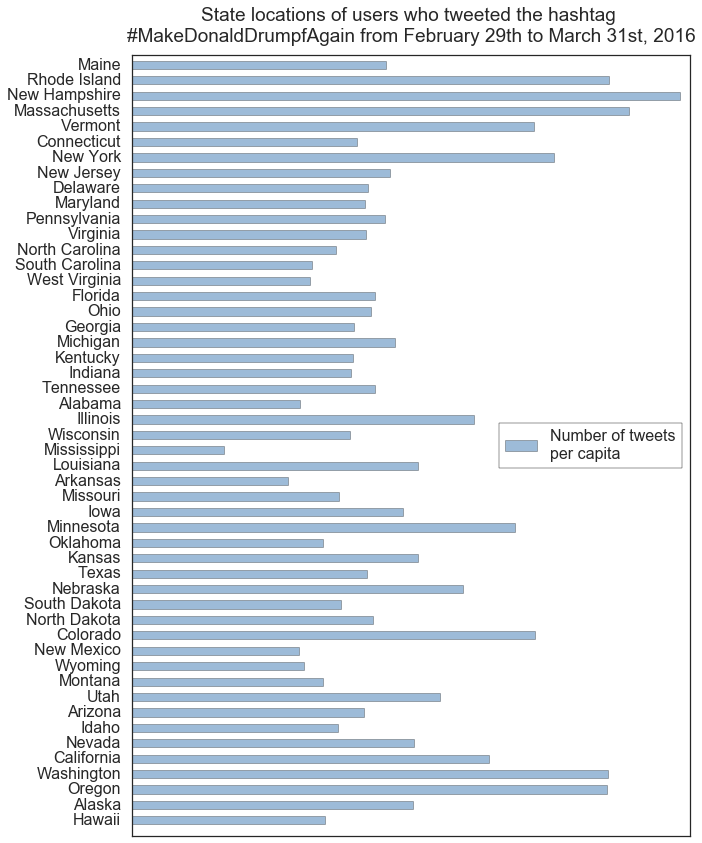

In [364]:
fig = plt.figure(figsize=(10,14))
sns.set_style('white')

mid_spacing = 1.5
x3 = np.arange(0,len(y3)*mid_spacing, mid_spacing)
x2 = [x+0.5 for x in x3]

print(len(x3), len(x2), len(y3), len(y2))

c = sns.color_palette('Blues')
c1 = sns.light_palette('navy')

plt.barh(x2, y3, align='center', color=c[5], alpha=0.4, height=0.8, lw=0.7,
         label='Number of tweets\nper capita')

plt.yticks(x2, labels)
plt.ylim(-1, len(y3)*mid_spacing)

plt.xticks([])
#plt.xlim(0,5)

#plt.title('Locations of users who tweeted the hashtag #makedonalddrumpfagain \ncollected from March 29th to April 20th, 2016',
#          y=1.01, fontsize=17, alpha=1)

#plt.legend(frameon=True, loc=(0.62, 0.71))
plt.legend(frameon=True, loc='best')

plt.title('State locations of users who tweeted the hashtag \n#MakeDonaldDrumpfAgain from February 29th to March 31st, 2016',
          y=1.01, fontsize=19, alpha=1)

plt.savefig('weighted_tweets_by_state.png', bbox_inches='tight', dpi=144)

plt.show()

In [75]:
# get ordered list
ordered_list = [(key, value) for key, value in zip(labels,y3)]
sorted(ordered_list, key=operator.itemgetter(1))

[('Mississippi', 57.54465397752387),
 ('Arkansas', 97.47115686206277),
 ('New Mexico', 104.48187359962542),
 ('Alabama', 105.45858781529898),
 ('Wyoming', 107.5305592457035),
 ('West Virginia', 111.45658458685747),
 ('South Carolina', 112.49900521447395),
 ('Oklahoma', 119.6886674350451),
 ('Montana', 120.01926944476413),
 ('Hawaii', 120.99975543038616),
 ('North Carolina', 128.01357064524373),
 ('Idaho', 129.23742895790744),
 ('Missouri', 129.90329474246863),
 ('South Dakota', 130.95980167558548),
 ('Wisconsin', 136.61479604286592),
 ('Indiana', 137.35065616288657),
 ('Kentucky', 138.42000646968597),
 ('Georgia', 138.8961518697962),
 ('Connecticut', 140.7981704923727),
 ('Arizona', 145.42149682602908),
 ('Maryland', 146.02915059970235),
 ('Virginia', 146.87614740345967),
 ('Texas', 147.21313873148918),
 ('Delaware', 147.93900989640028),
 ('Ohio', 149.7313205741942),
 ('North Dakota', 151.094453677801),
 ('Florida', 152.09384535187274),
 ('Tennessee', 152.09668382419196),
 ('Pennsylvan

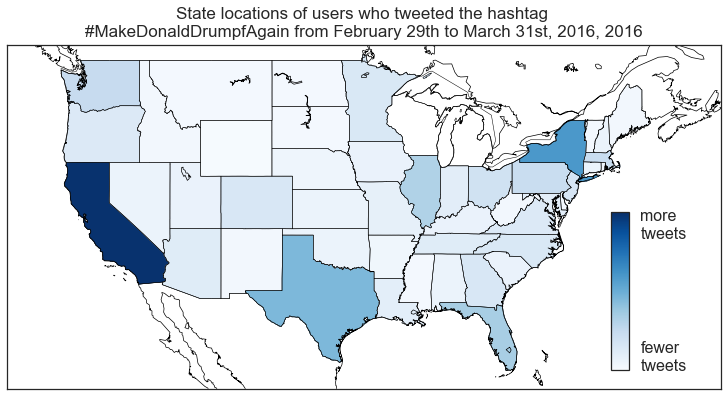

In [76]:
''' fake up a plot to define our color bar '''
x = np.linspace(-1.2,1.2,len(y0))
y = x
c = x
fig, ax = plt.subplots()
im = ax.scatter(x, y, c=c, cmap=plt.cm.Blues)
# Add a colorbar
fig.colorbar(im, ax=ax)
plt.close(fig)

''' Plotting y0=counts_per_state uncorrected for population '''

fig, ax = plt.subplots()

plt.title('State locations of users who tweeted the hashtag \n#MakeDonaldDrumpfAgain from February 29th to March 31st, 2016, 2016',
          y=1.01, fontsize=17, alpha=1)

my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 1000.0,
                     llcrnrlon=-130, llcrnrlat=23.5,
                     urcrnrlon=-60, urcrnrlat=50)
# do resolution='h' for high quality

my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(linewidth=0.7)

# load the shapefile, use the name 'states'
my_map.readshapefile('basemap_US_shapefiles/st99_d00',
                     name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in my_map.states_info:
    state_names.append(shape_dict['NAME'])

# get current axes instance and position
#ax = plt.gca()
#box = ax.get_position()

# plot the color bar
cbaxes = fig.add_axes([0.78, 0.27, 0.02, 0.25]) 
cbar = plt.colorbar(im, ax=ax, ticks=[-1,1], cax=cbaxes)  
cbar.ax.set_yticklabels(['fewer\ntweets', 'more\ntweets'])  # vertically oriented colorbar

color_number = 100
c = sns.color_palette("Blues", color_number)

for i, state in enumerate(labels):
    seg = my_map.states[state_names.index(state)]
    color = c[int(y0[i]/max(y0)*(color_number-1))]
    poly = Polygon(seg, facecolor=color, edgecolor=color)
    ax.add_patch(poly)
    
plt.show()

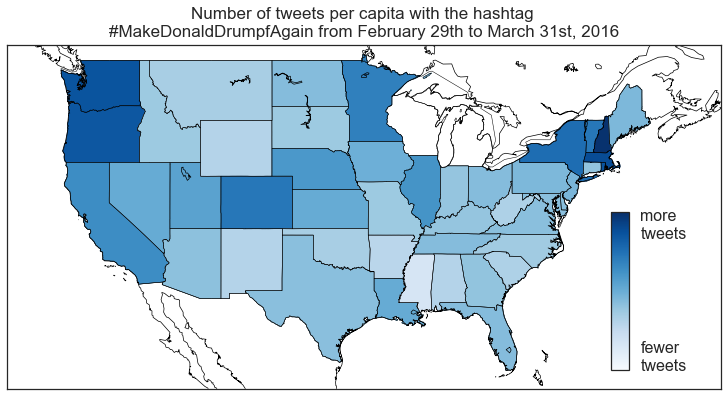

In [77]:
''' fake up a plot to define our color bar '''
x = np.linspace(-1.2,1.2,len(y0))
y = x
c = x
fig, ax = plt.subplots()
im = ax.scatter(x, y, c=c, cmap=plt.cm.Blues)
# Add a colorbar
fig.colorbar(im, ax=ax)
plt.close(fig)

''' Plotting y1=counts_per_state/population '''

fig, ax = plt.subplots()

plt.title('Number of tweets per capita with the hashtag \n#MakeDonaldDrumpfAgain from February 29th to March 31st, 2016',
          y=1.01, fontsize=17, alpha=1)

my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 1000.0,
                     llcrnrlon=-130, llcrnrlat=23.5,
                     urcrnrlon=-60, urcrnrlat=50)
# do resolution='h' for high quality

my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(linewidth=0.7)

# load the shapefile, use the name 'states'
my_map.readshapefile('basemap_US_shapefiles/st99_d00',
                     name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in my_map.states_info:
    state_names.append(shape_dict['NAME'])
    
# plot the color bar
cbaxes = fig.add_axes([0.78, 0.27, 0.02, 0.25]) 
cbar = plt.colorbar(im, ax=ax, ticks=[-1,1], cax=cbaxes)  
cbar.ax.set_yticklabels(['fewer\ntweets', 'more\ntweets'])  # vertically oriented colorbar

color_number = 100
c = sns.color_palette("Blues", color_number)

for i, state in enumerate(labels):
    seg = my_map.states[state_names.index(state)]
    color = c[int(y1[i]/max(y1)*(color_number-1))]
    poly = Polygon(seg, facecolor=color, edgecolor=color)
    ax.add_patch(poly)

plt.savefig('tweets_per_capita_by_state_map.png', bbox_inches='tight', dpi=144)
    
plt.show()

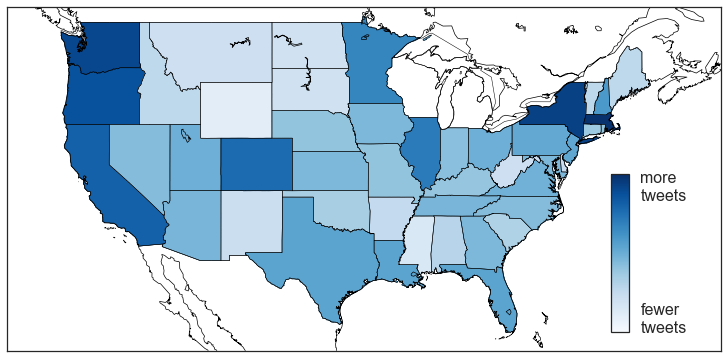

In [78]:
''' fake up a plot to define our color bar '''
x = np.linspace(-1.2,1.2,len(y0))
y = x
c = x
fig, ax = plt.subplots()
im = ax.scatter(x, y, c=c, cmap=plt.cm.Blues)
# Add a colorbar
fig.colorbar(im, ax=ax)
plt.close(fig)

''' Plotting y2=counts_per_state/electoral_votes '''

fig, ax = plt.subplots()

my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 1000.0,
                     llcrnrlon=-130, llcrnrlat=23.5,
                     urcrnrlon=-60, urcrnrlat=50)
# do resolution='h' for high quality

my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(linewidth=0.7)

# load the shapefile, use the name 'states'
my_map.readshapefile('basemap_US_shapefiles/st99_d00',
                     name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in my_map.states_info:
    state_names.append(shape_dict['NAME'])
    
# plot the color bar
cbaxes = fig.add_axes([0.78, 0.27, 0.02, 0.25]) 
cbar = plt.colorbar(im, ax=ax, ticks=[-1,1], cax=cbaxes)  
cbar.ax.set_yticklabels(['fewer\ntweets', 'more\ntweets'])  # vertically oriented colorbar

color_number = 100
c = sns.color_palette("Blues", color_number)

for i, state in enumerate(labels):
    seg = my_map.states[state_names.index(state)]
    color = c[int(y2[i]/max(y2)*(color_number-1))]
    poly = Polygon(seg, facecolor=color, edgecolor=color)
    ax.add_patch(poly)

plt.show()

### Using basemap to plot tweet lattitude and longitude

In [79]:
m1 = Basemap(projection='ortho', lat_0=50, lon_0=-100,
                 resolution='l', area_thresh=1000.0)
m1.llcrnrx
m1.llcrnry

0.0

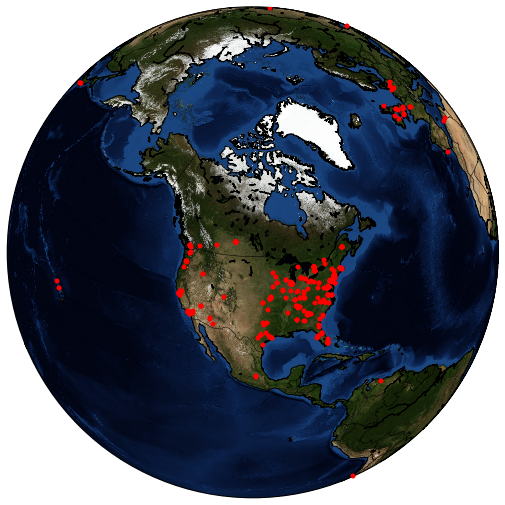

In [80]:
m1 = Basemap(projection='ortho', lat_0=50, lon_0=-100,
                 resolution='l', area_thresh=1000.0)

my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
                 resolution='l', area_thresh=1000.0,
                 llcrnrx=0.0,
                 llcrnry=0.0)
                 #urcrnrx=0.0,
                 #urcrnry=0.0)
                 #urcrnrx=m1.urcrnrx*0.3,
                 #urcrnry=m1.urcrnry*0.1)

my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines()
my_map.bluemarble()

longs = list(df.loc[(df.long != 'NaN')].long)
latts = list(df.loc[df.latt != 'NaN'].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=5)

plt.show()

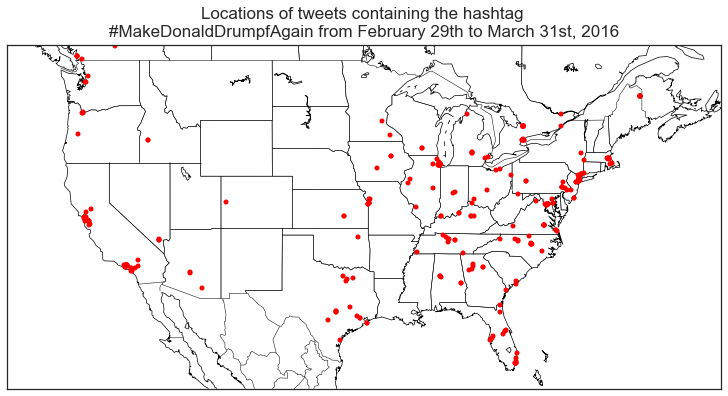

In [81]:
my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 1000.0,
                     llcrnrlon=-130, llcrnrlat=23.5,
                     urcrnrlon=-60, urcrnrlat=50)
# do resolution='h' for high quality

my_map.drawcountries()
my_map.drawstates()
my_map.drawcoastlines(linewidth=0.7)

#longs = list(df.loc[(df.long != 'NaN')].long)
#latts = list(df.loc[df.latt != 'NaN'].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=5)

plt.title('Locations of tweets containing the hashtag \n#MakeDonaldDrumpfAgain from February 29th to March 31st, 2016',
          y=1.01, fontsize=17, alpha=1)

plt.savefig('drumpf_tweet_locations.png', bbox_inches='tight', dpi=144)

plt.show()

In [357]:
print(len(longs))

402


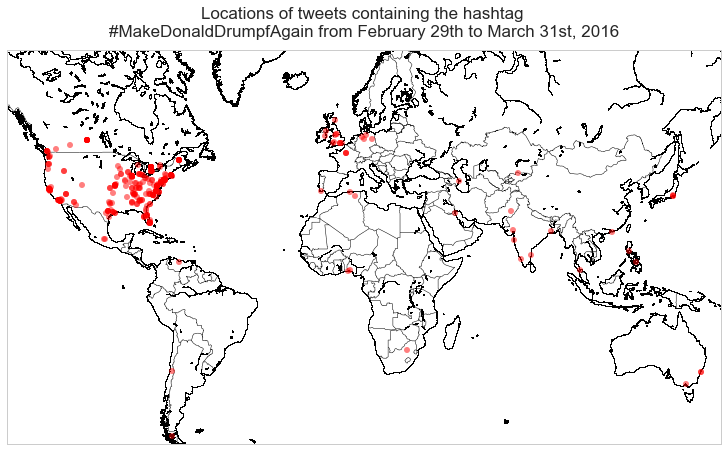

In [356]:
my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 1000.0,
                     llcrnrlon=-140, llcrnrlat=-55,
                     urcrnrlon=160, urcrnrlat=70)
# set resolution='h' for high quality

my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(antialiased=False,
                      linewidth=0.005)

longs = list(df.loc[(df.long != 'NaN')].long)
latts = list(df.loc[df.latt != 'NaN'].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=6, alpha=0.5)

plt.title('Locations of tweets containing the hashtag \n#MakeDonaldDrumpfAgain from February 29th to March 31st, 2016', y=1.02, fontsize=17, alpha=1)
plt.savefig('drumpf_tweet_locations_world.png', bbox_inches='tight', dpi=144)
plt.show()

In [83]:
print(len(longs))

402


### histogram comparing original tweets to retweets (RT)

In [11]:
if True:
    df = drumpf_dataframe

    # convert and sort
    dates = list(df.created_at)
    all_dates = [dt.datetime.strptime(d, '%a %b %d %H:%M:%S +0000 %Y') for d in dates]
    #all_dates.sort() # WHY WOULD YOU SORT IDIOT YOU FUCK UP THE ORDER
    df.created_at = all_dates

    # convert created_at column to dates from strings
    all_dates = list(df.created_at)

    drumpf_dataframe.head()

TypeError: must be str, not Timestamp

In [13]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

date_utc = df.created_at[0].replace(tzinfo=from_zone)

# Convert time zone
date_est = date_utc.astimezone(to_zone)
print(date_utc.hour)
print(date_est.hour)

#now_aware = df.created_at[0].replace(tzinfo=pytz.UTC)
#now_aware

print('Okay so the offset is 5 hours - that makes sense and means'
      ' I am not missing that hour of data I thought I was')

23
18
Okay so the offset is 5 hours - that makes sense and means I am not missing that hour of data I thought I was


In [14]:
dates = [df.created_at[i] for i in range(10)]
print(dates)
print(min(dates))

[Timestamp('2016-02-29 23:59:59'), Timestamp('2016-02-29 23:59:40'), Timestamp('2016-02-29 23:59:23'), Timestamp('2016-02-29 23:59:05'), Timestamp('2016-02-29 23:58:43'), Timestamp('2016-02-29 23:58:23'), Timestamp('2016-02-29 23:58:05'), Timestamp('2016-02-29 23:57:48'), Timestamp('2016-02-29 23:57:28'), Timestamp('2016-02-29 23:57:10')]
2016-02-29 23:57:10


In [15]:
''' Now it's a good idea to sort the dates '''
all_dates.sort()

In [16]:
''' these comprehensions don't work :( '''
#original_dates = list(df.loc[('RT' not in df.text)].created_at)
#RT_dates = list(df.loc[('RT' in df.text)].created_at)

" these comprehensions don't work :( "

In [17]:
a = [1, 2, 3, 4]
a[:2]

[1, 2]

In [18]:
orig_dates = []
RT_dates = []
j = 0
for i in df.index:
    if df.loc[i, 'text'].split()[0] == 'RT':
        RT_dates.append(df.loc[i, 'created_at'])
    else:
        orig_dates.append(df.loc[i, 'created_at'])
    j += 1

In [19]:
#t0 = all_dates[0] - dt.timedelta(hours=all_dates[0].hour,
#                                 minutes=all_dates[0].minute)
#print(t0)

#bin_number = 200
#date_range = all_dates[-1] - t0
#date_labels = []
#for i in range(bin_number):
#    if i%20 == 0:
#        date = t0 + i*date_range/bin_number
#        date_labels.append(date.strftime('%b %d, %H'))

In [20]:
# ''' alternative bin labelling scheme (still not ideal),
#     it seems to be accurate to within about an hour in
#     this case '''

# # get start of the first day
# # all other tweets will be plotted relative
# # to this on the histogram
# bin_number = 400
# t0 = all_dates[0] - dt.timedelta(hours=all_dates[0].hour,
#                                  minutes=all_dates[0].minute)
# print(t0)

# date_range = all_dates[-1] - t0
# date_labels, date_ticks = [], []
# next_day = t0.day
# for i in range(bin_number):
#     date = t0 + i*date_range/(bin_number-1)
#     if date.day == next_day:
#         print('make a tick at', i/(bin_number-1)*100, '%')
#         date_ticks.append(i)
#         date_labels.append(date.strftime('%b %d'))
#         next_day = (date + dt.timedelta(days=1)).day
            
# # pad the date labels with some white space to center them in the histogram
# #date_labels = ['               '+d for d in date_labels]

In [21]:
#print((date_labels))

In [22]:
now = min(all_dates) - dt.timedelta(hours=5)
t0 = now - dt.timedelta(hours=now.hour,
                        minutes=now.minute)

print(t0)

2016-02-28 00:00:18


In [23]:
if True:

    ''' Converting to Eastern time (EST) from Coordinated Universal Time (UTC) '''
    EST_convert = -5
    d_all = [(t - t0).days*24 + t.hour + t.minute/60.0 + EST_convert for t in all_dates]
    d_orig = [(t - t0).days*24 + t.hour + t.minute/60.0 + EST_convert for t in orig_dates]
    d_RT = [(t - t0).days*24 + t.hour + t.minute/60.0 + EST_convert for t in RT_dates]

print(d_all[:10])

[23.483333333333334, 23.483333333333334, 23.483333333333334, 23.5, 23.5, 23.5, 23.516666666666666, 23.516666666666666, 23.516666666666666, 23.533333333333335]


days 31
bin time delta 3.839722222222222
34
tick error (int/float=1 ideally): 0.9599305555555554


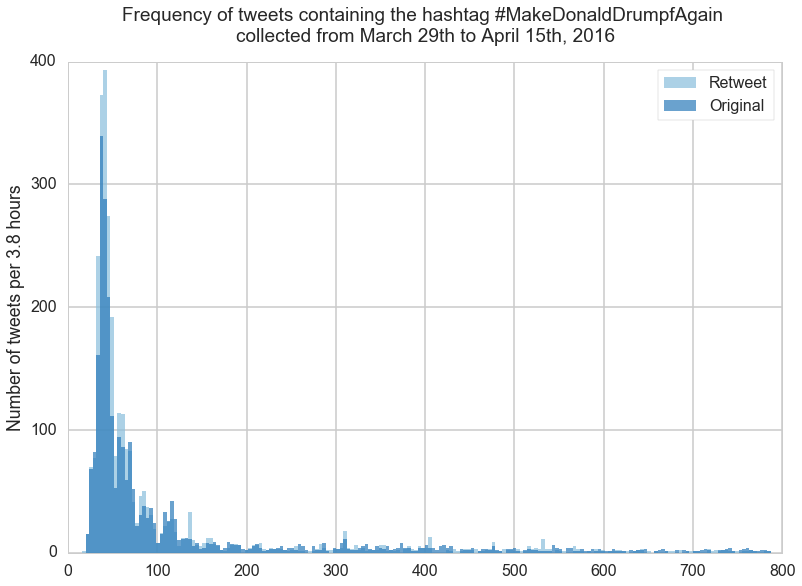

In [24]:
''' Don't trust this plot! '''

sns.set_style('whitegrid')

bin_number = 200

t0 = all_dates[0] - dt.timedelta(hours=all_dates[0].hour,
                                 minutes=all_dates[0].minute)
    
date_range = all_dates[-1] - t0
d = date_range/bin_number
bin_time_delta = d.days*24 + d.seconds/60/60
bins = np.linspace(0, d_all[-1], bin_number)

print('days', date_range.days)
print('bin time delta', bin_time_delta)

fig = plt.figure()
ax = fig.add_subplot(111)

c = sns.color_palette('Blues')

#ax.hist(d_all, bins=np.arange(0, bin_number), linewidth=0, alpha=0.7, color='black')
ax.hist(d_RT, bins=bins, linewidth=0, alpha=0.7, color=c[2], label='Retweet')
ax.hist(d_orig, bins=bins, linewidth=0, alpha=0.7, color=c[4], label='Original')

ytks = ax.yaxis.get_major_ticks()
for ytk in ytks[1::2]:
    ytk.set_visible(False)

#ax.xaxis.set_ticks(np.arange(0, bin_number, 20))
#ax.set_xticklabels(date_labels, rotation=0, fontsize=15)
#ax.set_xlim(0,200)

xtick_d = 24/bin_time_delta
xticks = bins[::int(xtick_d)]
print(len(xticks))
print('tick error (int/float=1 ideally):', int(xtick_d)/xtick_d)
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(date_labels, rotation=90, fontsize=15)

ax.set_title('Frequency of tweets containing the hashtag #MakeDonaldDrumpfAgain \ncollected from March 29th to April 15th, 2016', y=1.03, fontsize=19, alpha=1)
ax.set_ylabel('Number of tweets per {0:.1f} hours'.format(bin_time_delta))
ax.legend(frameon=True)

plt.show()

1.9 1.9391666666666665


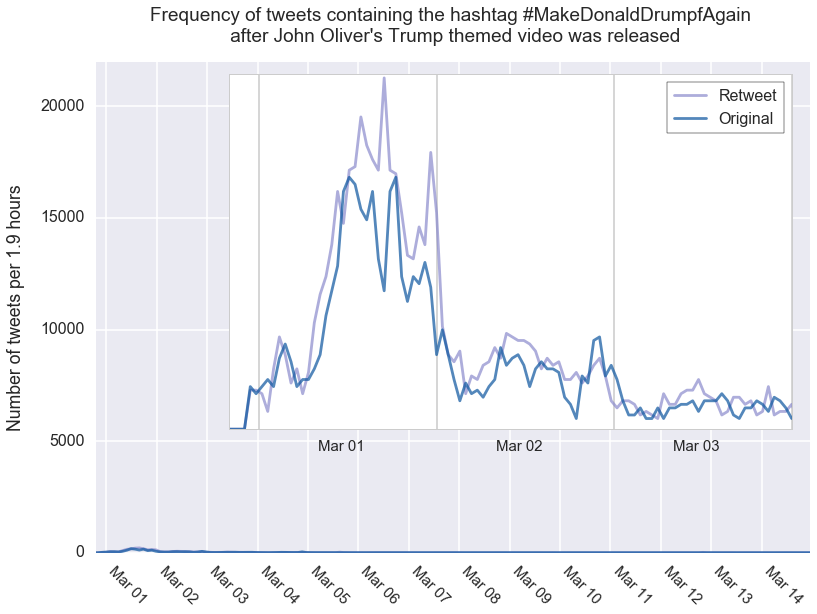

In [25]:
sns.set_style('darkgrid')

# will have to tune bin number (probably make it a bit smaller)
# depending on how close the final tweet was to the end of the day
# note: 24hours*32days = 768bins
bin_number = 396

date_range = all_dates[-1] - t0
d = date_range/bin_number
bin_time_delta = d.days*24 + d.seconds/60/60
bins = np.linspace(0, d_all[-1], bin_number+1)

fig = plt.figure()
ax = fig.add_subplot(111)

c1 = sns.light_palette('navy')
c2 = sns.color_palette('Blues')

tweet_hist_1 = np.histogram(d_RT, bins=bins)
tweet_hist_2 = np.histogram(d_orig, bins=bins)

x = tweet_hist_1[1][:-1]
y1 = tweet_hist_1[0]
y2 = tweet_hist_2[0]

ax.plot(x, y1, alpha=0.7, color=c1[2], label='Retweet')
ax.plot(x, y2, alpha=0.7, color=c2[5], label='Original')
            
#ytks = ax.yaxis.get_major_ticks()
#for ytk in ytks[1::2]:
#    ytk.set_visible(False)

# x-axis labels
xtks, xlabs = [], []
next_day = 0
for day in range(date_range.days+2):
    date = t0 + dt.timedelta(hours=next_day)
    xtks.append(next_day)
    xlabs.append(date.strftime('%b %d'))
    next_day += 24

ax.xaxis.set_ticks(xtks)
ax.set_xticklabels(xlabs[:-1], rotation=-45, fontsize=15, ha='left')

title = "Frequency of tweets containing the hashtag #MakeDonaldDrumpfAgain \n after John Oliver's Trump themed video was released"
ax.set_title(title, y=1.03, fontsize=19, alpha=1)

btd = '%.1f' % round(bin_time_delta, 1)
print(btd, bin_time_delta)
if btd == 1.0:
    ylab = 'Number of tweets per hour'.format(bin_time_delta)
else:
    ylab = 'Number of tweets per {0:.1f} hours'.format(bin_time_delta)

ax.set_ylabel(ylab, labelpad=15)

ax.set_ylim(0,22000)
ax.set_xlim(19,359)



''' Add a more detailed inset plot '''

sns.set_style('whitegrid')
left, bottom, width, height = [0.27, 0.32, 0.61, 0.56]
ax_inset = fig.add_axes([left, bottom, width, height])

bin_number = 1000

d = date_range/bin_number
bin_time_delta = d.days*24 + d.seconds/60/60
bins = np.linspace(0, d_all[-1], bin_number+1)

tweet_hist_3 = np.histogram(d_RT, bins=bins)
tweet_hist_4 = np.histogram(d_orig, bins=bins)

x = tweet_hist_3[1][:-1]
y3 = tweet_hist_3[0]
y4 = tweet_hist_4[0]

ax_inset.plot(x, y3, alpha=0.7, color=c1[2], label='Retweet')
ax_inset.plot(x, y4, alpha=0.7, color=c2[5], label='Original')
            
#ytks = ax.yaxis.get_major_ticks()
#for ytk in ytks[1::2]:
#    ytk.set_visible(False)

# x-axis labels
xtks, xlabs = [], []
next_day = 0
for day in range(5):
    date = t0 + dt.timedelta(hours=next_day)
    xtks.append(next_day)
    xlabs.append('                                        '+date.strftime('%b %d'))
    next_day += 24

ax_inset.xaxis.set_ticks(xtks)
ax_inset.set_xticklabels(xlabs[:-1], rotation=0, fontsize=15)
ax_inset.set_xlim(20,96)
#ax_inset.set_ylim(0,20500)
ax_inset.set_yticklabels([])
ax_inset.set_yticks([])
#ax_inset.set_ylabel('Number of tweets per {0:.1f} hours'.format(bin_time_delta))


# change color of legend box
legend = ax_inset.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('drumpf_tweet_frequency.png', bbox_inches='tight', dpi=144)

plt.show()

3.9 3.8786111111111112


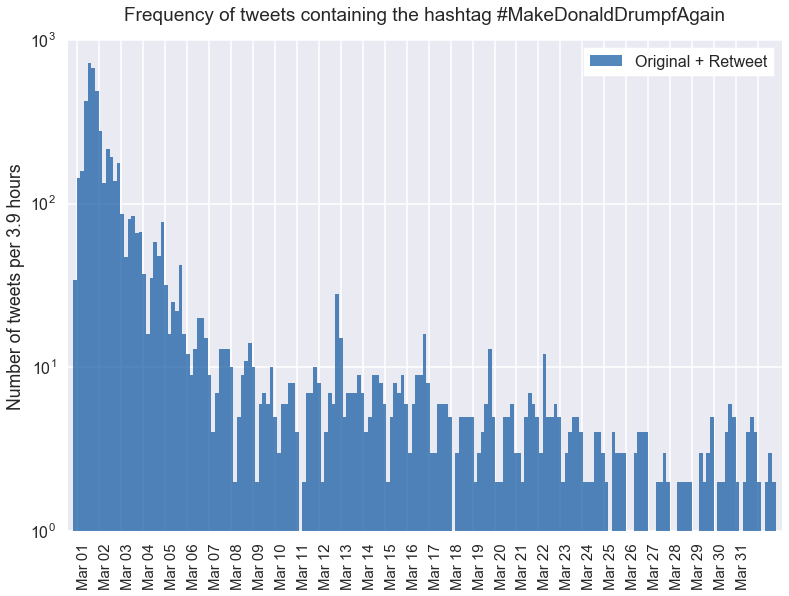

In [26]:
sns.set_style('darkgrid')

bin_number = 198

date_range = all_dates[-1] - t0
d = date_range/bin_number
bin_time_delta = d.days*24 + d.seconds/60/60
bins = np.linspace(0, d_all[-1], bin_number+1)

fig = plt.figure()
ax = fig.add_subplot(111)

c1 = sns.light_palette('navy')
c2 = sns.color_palette('Blues')

tweet_hist = np.histogram(d_all, bins=bins)
x = tweet_hist[1][:-1]
y = tweet_hist[0]

#ax.semilogy(x, y, alpha=0.7, color=c2[5], label='Original + Retweet')
#ax.bar(x, y, alpha=0.7, color=c2[5], label='Original + Retweet', log=True)
ax.hist(d_all, bins, linewidth=0, alpha=0.7, color=c[5], label='Original + Retweet', log=True)

# x-axis labels
xtks, xlabs = [], []
next_day = 0
for day in range(date_range.days+2):
    date = t0 + dt.timedelta(hours=next_day)
    xtks.append(next_day)
    xlabs.append(date.strftime('%b %d'))
    next_day += 24

ax.xaxis.set_ticks(xtks)
ax.set_xticklabels(xlabs[:-1], rotation=90, fontsize=15, ha='left')

ax.set_title('Frequency of tweets containing the hashtag #MakeDonaldDrumpfAgain', y=1.03, fontsize=19, alpha=1)
btd = '%.1f' % round(bin_time_delta, 1)
print(btd, bin_time_delta)
if btd == 1.0:
    ylab = 'Number of tweets per hour'.format(bin_time_delta)
else:
    ylab = 'Number of tweets per {0:.1f} hours'.format(bin_time_delta)

ax.set_ylabel(ylab)

# change color of legend box
legend = ax.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')

ax.set_xlim(14,794)

plt.savefig('drumpf_tweet_frequency_log.png', bbox_inches='tight', dpi=144)

plt.show()

### Future Tasks
- how long between tweets and retweets?
- histogram of other most common hashtags in tweets
- histogram of most common people tweeted @

### How long between tweets and retweets

In [28]:
df3 = drumpf_dataframe

# # convert datetimes
# dates = list(df.created_at)
# all_dates = [dt.datetime.strptime(d, '%a %b %d %H:%M:%S +0000 %Y') for d in dates]

# # replace column
# df.created_at = all_dates

In [29]:
df3.dtypes

user                    object
text                    object
created_at      datetime64[ns]
location                object
country_code            object
long                    object
latt                    object
dtype: object

In [30]:
retweet_intervals = {}
for i in list(df3.index):#[:limit]:
    t = df3.text[i]
    if t.split()[0] == 'RT':
        #d = df3.created_at[i]
        u = t.split()[1][1:-1]
        retweet_intervals[t] = [u]

original_tweets = {}
no_retweets = []
#j = 0
for i in list(df3.index):#[:limit]:
    t = df3.text[i]
    if t.split()[0] == 'RT':
        #t2 = ' '.join(t.split()[2:])
        if t in retweet_intervals.keys():
            d = df3.created_at[i]
            retweet_intervals[t].append(d)
            #u = t.split()[1][1:-1]
            #print('found tweet match, cheking users:', u, retweet_intervals[t2][0])
            #print('for text as a key', t2)
            #if retweet_intervals[t2][0] == u:
            #    d = df3.created_at[i]
            #    retweet_intervals[t2].append(d)
                #retweet_intervals[t2].append(t)
                
for i in list(df3.index):#[:limit]:
    t = df3.text[i]
    if t.split()[0] != 'RT':
        d = df3.created_at[i]
        u = df3.user[i]
        original_tweets[t] = [u, d]
        RT = 'RT '+'@'+u+': '+t
        if RT not in retweet_intervals.keys():
            #print('no RT original', t)
            no_retweets.append(d)
#    j += 1

print(len(retweet_intervals))
print(len(no_retweets))

1648
2540


In [31]:
# for i in df.index[:limit]:
#     if 'AngelJi95809364' in df.text[i] or df.user[i] == 'AngelJi95809364':
#         print(i)
#         print(df.loc[i])
#         print('')

In [32]:
# for i in retweet_intervals:
#     if len(retweet_intervals[i]) > 2:
#         print(retweet_intervals[i])
#         print('')

In [33]:
# # Find empty elements in dictionary,
# # i.e. original tweets that never got retweeted :(,
# # and set them aside for later
# no_retweets = []
# for key in retweet_intervals.keys():
#     if len(retweet_intervals[key]) == 2:
#         no_retweets.append(retweet_intervals[key][1])

# print(len(no_retweets))

In [34]:
# retweet_intervals

In [35]:
bins = 100
total_t = max(no_retweets) - min(no_retweets)
total_t/bins

Timedelta('0 days 07:37:05.930000')

In [36]:
to_timestamp = np.vectorize(lambda x: x.timestamp())

time_stamps = to_timestamp(no_retweets)
noRT_hist = np.histogram(time_stamps, bins=100)
noRT_times = [dt.datetime.fromtimestamp(t) for t in noRT_hist[1][:-1]]

time_stamps = to_timestamp(list(df.created_at))
RT_hist = np.histogram(time_stamps, bins=100)
RT_times = [dt.datetime.fromtimestamp(t) for t in RT_hist[1][:-1]]

In [310]:
sns.set_style('white')

''' Plot a histogram of non-retweeted '''
fig, ax = plt.subplots()

dates = mpl.dates.date2num(no_retweets)

ax.hist(no_retweets, bins=bins)
ax.set_ylabel('Number of tweets per ~7.5 hours')
ax.set_title('"Lonely" tweets - posts containing the hashtag \n#MakeDonaldDrumpfAgain that were not retweeted',
             y=1.03, fontsize=15, alpha=1)

# Adding an inset plot
left, bottom, width, height = [0.27, 0.3, 0.61, 0.56]
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.plot(RT_times, noRT_hist[0]/RT_hist[0])
ax_inset.set_ylabel('Fraction of tweets that are "lonely"')

plt.show()

ValueError: ordinal must be >= 1

In [38]:
''' Making a list of times between tweets and retweets in hours. '''

retweet_intervals_list = []
for v in retweet_intervals.values():
    for i, val in enumerate(v):
        if i == 0:
            continue
        elif i == 1:
            t0 = val
        else:
            td = val - t0
            retweet_intervals_list.append(td.days + td.seconds/60.0/60.0/24.0)

print(retweet_intervals_list[:100])

[-0.06179398148148152, -0.1264467592592592, -0.2203356481481481, 0.2766898148148148, 11.07681712962963, 20.900983796296295, -0.000497685185185226, -0.19767361111111115, -0.23297453703703708, -0.20857638888888885, -0.3808796296296296, -0.38173611111111116, -0.406875, -0.009178240740740695, -0.1466666666666666, -0.3281481481481481, -0.37001157407407415, -0.38559027777777777, -0.4175000000000001, -0.4258912037037037, -0.43497685185185186, -0.43570601851851853, 0.6513310185185185, -0.011770833333333397, -0.016273148148148286, 0.6694907407407408, 1.2340277777777777, -0.12533564814814813, -0.06344907407407396, -0.09108796296296306, -0.09865740740740747, -0.11266203703703714, 2.092465277777778, -0.23402777777777783, -0.1693055555555555, -0.19035879629629626, -0.19142361111111128, -0.19256944444444446, -0.19349537037037046, -0.20216435185185178, -0.20614583333333325, -0.21497685185185178, -0.21835648148148146, -0.21857638888888886, 0.05553240740740741, 12.723101851851851, -0.09886574074074073,

In [39]:
print(xtks)
xlab = [int(tk/100*len(xtks)) for tk in xtks]
xlab

[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 744, 768]


[0,
 7,
 15,
 23,
 31,
 39,
 47,
 55,
 63,
 71,
 79,
 87,
 95,
 102,
 110,
 118,
 126,
 134,
 142,
 150,
 158,
 166,
 174,
 182,
 190,
 198,
 205,
 213,
 221,
 229,
 237,
 245,
 253]

6.78 seconds per bin
17.70251599666638
1.93106915509
percent area 0.843891402715


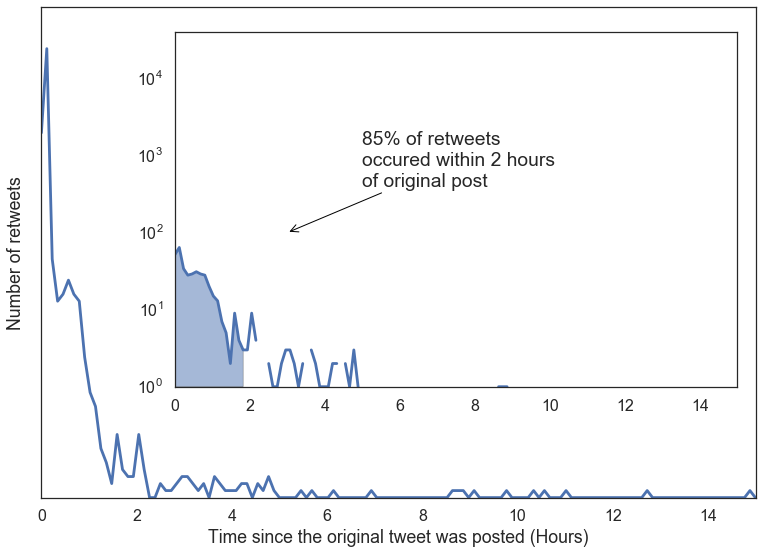

In [56]:
fig, ax = plt.subplots()

# ax.set_title('Exponential decay of retweet frequency', y=1.03, fontsize=19, alpha=1)
ax.set_ylabel('Number of retweets')
ax.set_xlabel('Time since the original tweet was posted (Hours)')

x_max = max(retweet_intervals_list)
N_bins = 185

print(round(x_max/N_bins,4)*60, 'seconds per bin')

bins = np.linspace(0,x_max,N_bins)
hist = np.histogram(retweet_intervals_list, bins=bins)
ax.plot(hist[1][:-1], hist[0])
ax.set_yticklabels([])
ax.set_xlim(0,15)

# N_lab = 6
# xtks = np.linspace(0,100,N_lab)
# xlab = [hist[1][int(tk/100*(N_bins-1))] for tk in xtks]
# xlab = ['%.1f' % round(tk, 1) for tk in xlab]
# ax.set_xticklabels(xlab)
# ax.set_xticks(xtks)

# Add an inset plot
left, bottom, width, height = [0.27, 0.3, 0.61, 0.56]
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.semilogy(hist[1][:-1], hist[0])
ax_inset.set_xlim(0,15)
ax_inset.set_ylim(1, 40000)

ax_fill = fig.add_axes([left, bottom, width, height])
ff = N_bins*2/x_max
ax_fill.fill_between(hist[1][:int(ff)], 1, hist[0][:int(ff)], alpha=0.5)
# ax_inset.vlines(ff*x_max/N_bins, 1, 1000, alpha=0.7)
ax_inset.annotate('85% of retweets'+'\n'+'occured within 2 hours'+'\n'+'of the original post',
                  xy=(3, 100), xytext=(5, 400),
                  xycoords='data', textcoords='data',# ha='right', va='bottom', 
                  arrowprops=dict(arrowstyle='->', lw=1))

''' How much area is in the shaded part? '''
area = sum(hist[0][:int(ff)])/sum(hist[0])
print(ff)
print(hist[1][int(ff)])
print('percent area', area)

plt.show()

### Histogram of other most common hashtags in tweets and most common people tweeted @

In [277]:
import itertools
from collections import Counter

def sorted_frequency(listOfWords, flatten=True):
    ''' Use collections.Counter to see most common words.
        Assumes input of 2D list and will flatten it.'''

    def flatten(listOfLists):
        "Flatten one level of nesting"
        return itertools.chain.from_iterable(listOfLists)    

    if flatten:
        words = flatten(listOfWords)
    else:
        words = listOfWords

    word_counts = dict(Counter(list(words)))
    words = [(a, b) for a, b in word_counts.items()]
    words = sorted(words, key=operator.itemgetter(1))
    return words[::-1]

all_tweet_words = []
for t in original_tweets.keys():
    line = []
    for l in t.split():
        if l[-1] == '.':
            line.append(l.split('.')[0])
        else:
            line.append(l)
    all_tweet_words.append(line)

all_w = sorted_frequency(all_tweet_words)
all_w[:100]

[('#MakeDonaldDrumpfAgain', 1984),
 ('the', 437),
 ('to', 404),
 ('is', 324),
 ('a', 279),
 ('of', 240),
 ('I', 238),
 ('@realDonaldTrump', 212),
 ('and', 192),
 ('you', 190),
 ('Donald', 188),
 ('Trump', 183),
 ('John', 183),
 ('#makedonalddrumpfagain', 163),
 ('for', 158),
 ('this', 141),
 ('@iamjohnoliver', 134),
 ('it', 128),
 ('Oliver', 127),
 ('#NeverTrump', 118),
 ('on', 118),
 ('in', 113),
 ('Drumpf', 107),
 ('that', 100),
 ('with', 94),
 ('@LastWeekTonight', 92),
 ('be', 81),
 ('via', 74),
 ('have', 73),
 ('his', 72),
 ('are', 70),
 ('your', 65),
 ('The', 65),
 ('my', 60),
 ('just', 60),
 ('This', 60),
 ('he', 59),
 ('like', 58),
 ('at', 56),
 ('all', 56),
 ('not', 54),
 ('#SuperTuesday', 52),
 ('as', 49),
 ('best', 48),
 ('so', 47),
 ('from', 46),
 ('about', 44),
 ('Last', 44),
 ('Week', 44),
 ('Tonight', 43),
 ('can', 42),
 ('has', 42),
 ('was', 41),
 ('will', 41),
 ('if', 40),
 ('we', 40),
 ('do', 40),
 ('vote', 39),
 ('#Trump', 39),
 ('but', 39),
 ("I'm", 38),
 ('&amp;', 3

In [ ]:
top_words = []

data = [(word, all_w[word]) for word in top_words]
colors = sns.color_palette("YlGnBu", 10)

plt.figure(figsize=(14, 7))
plt.title('Users mentioned in #MakeDonaldDrumphAgain tweets', y=1.03, fontsize=15)
ax = plt.subplot(111)
y = [a[1] for a in data]
x = [i for i in range(len(y))]
ax.bar(x, y, color=colors[::-1])
ax.set_xticks(x)
ax.set_xticklabels([a[0] for a in data], rotation=60)
ax.set_xlim(-0.2, 10)

In [281]:
hash_w = []
for a, b in all_w:
    try:
        if a[0] == '#':
            hash_w.append((a, b))
    except:
        pass
        
hash_w[:10]

 15


[('#MakeDonaldDrumpfAgain', 1984),
 ('#makedonalddrumpfagain', 163),
 ('#NeverTrump', 118),
 ('#SuperTuesday', 52),
 ('#Trump', 39),
 ('#GOPDebate', 33),
 ('#DumpTrump', 29),
 ('#Drumpf', 23),
 ('#Trump2016', 22),
 ('#DonaldTrump', 21)]

(-0.2, 10)

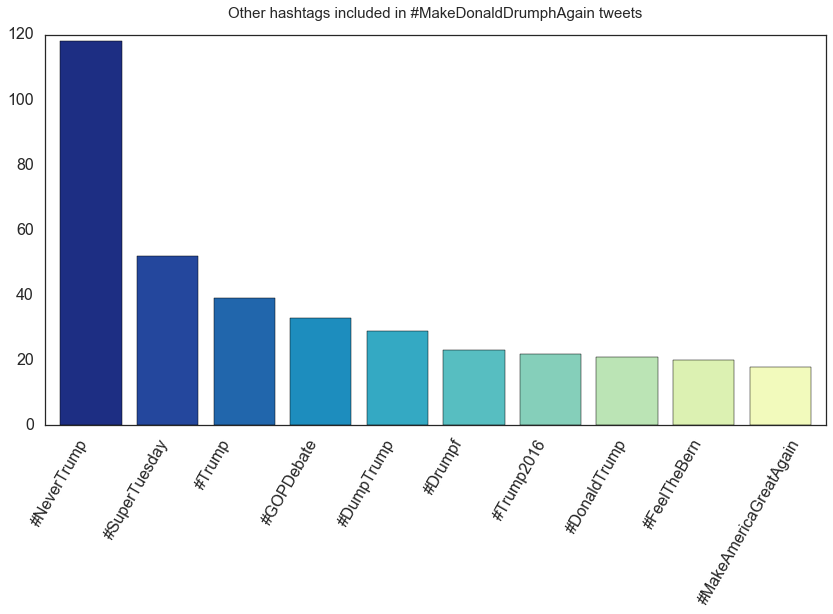

In [297]:
data = hash_w[2:12]
colors = sns.color_palette("YlGnBu", 10)

plt.figure(figsize=(14, 7))
plt.title('Other hashtags included in #MakeDonaldDrumphAgain tweets', y=1.03, fontsize=15)
ax = plt.subplot(111)
y = [a[1] for a in data]
x = [i for i in range(len(y))]
ax.bar(x, y, color=colors[::-1])
ax.set_xticks(x)
ax.set_xticklabels([a[0] for a in data], rotation=60)
ax.set_xlim(-0.2, 10)
plt.savefig('figures/top_hashtags.png', bbox_inches='tight', dpi=144)

In [282]:
user_mention_w = []
for a, b in all_w:
    try:
        if a[0] == '@':
            user_mention_w.append((a, b))
    except:
        pass
        
user_mention_w[:10]

[('@realDonaldTrump', 212),
 ('@iamjohnoliver', 134),
 ('@LastWeekTonight', 92),
 ('@YouTube', 31),
 ('@guillaumecampa', 11),
 ('@HuffPostComedy', 8),
 ('@marcorubio', 7),
 ('@BernieSanders', 6),
 ('@RealDonalDrumpf', 6),
 ('@MittRomney', 5)]

(-0.2, 10)

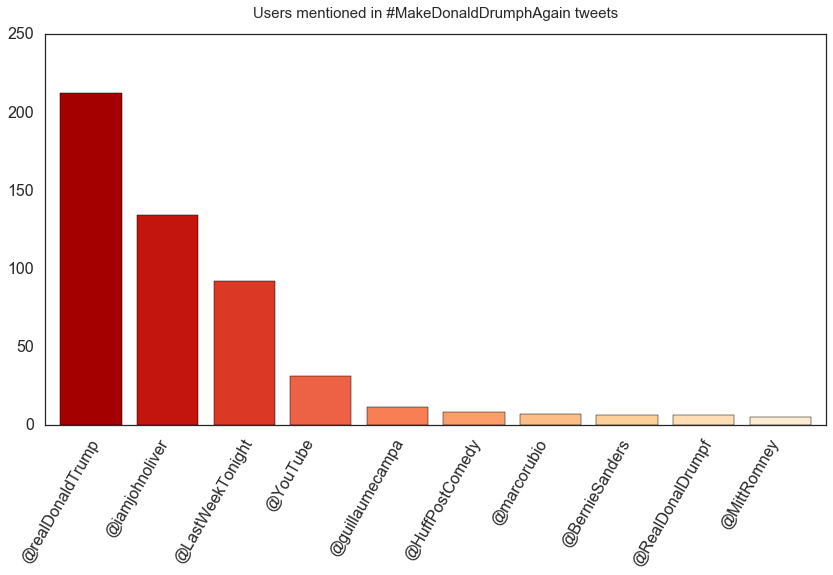

In [286]:
data = user_mention_w[:10]
colors = sns.color_palette("OrRd", 10)

plt.figure(figsize=(14, 7))
plt.title('Users mentioned in #MakeDonaldDrumphAgain tweets', y=1.03, fontsize=15)
ax = plt.subplot(111)
y = [a[1] for a in data]
x = [i for i in range(len(y))]
ax.bar(x, y, color=colors[::-1])
ax.set_xticks(x)
ax.set_xticklabels([a[0] for a in data], rotation=60)
ax.set_xlim(-0.2, 10)
plt.savefig('figures/top_users_mentioned.png', bbox_inches='tight', dpi=144)

#### Where is the love at?

Searching for words *containing*: love, hate, God, and various profanities. e.g. #HateDonald would register a count.

In [126]:
all_w_dict = {a: b for a, b in all_w}

In [152]:
custom_word_count = {'God': 0, 'Love': 0, 'Hate': 0, 'Profanity': 0}
profanity_details = {'Shit': 0, 'Asshole': 0, 'Douchebag': 0, 'Bitch': 0,
                     'Fuck': 0, 'Faggot': 0, 'Cunt': 0, 'Motherfucker': 0}
custom = ['God', 'god', 'Love', 'love', 'Hate', 'hate']
profanity = ['Shit', 'shit', 'Asshole', 'asshole', 'Douchebag', 'douchebag', 'Bitch', 'bitch',
             'Fuck', 'fuck', 'Faggot', 'faggot', 'Cunt', 'cunt', 'Motherfucker', 'motherfucker']

f = open('profanity_tweets.dat', 'wb')
for tweet in all_tweet_words:
    for word in tweet:
        for w in custom:
            if w in word:
                if w == 'God' or w == 'god':
                    custom_word_count['God'] += 1
                elif w == 'Love' or w == 'love':
                    custom_word_count['Love'] += 1
                elif w == 'Hate' or w == 'hate':
                    custom_word_count['Hate'] += 1
                else:
                    print('Error', w)
            
        for p in profanity:
            if p in word:
                f.write((' '.join(tweet)+'\n').encode('utf-8'))
                custom_word_count['Profanity'] += 1
                if p == 'Shit' or p == 'shit':
                    profanity_details['Shit'] += 1
                elif p == 'Fuck' or p == 'fuck':
                    profanity_details['Fuck'] += 1
                elif p == 'Douchebag' or p == 'douchebag':
                    profanity_details['Douchebag'] += 1
                elif p == 'Bitch' or p == 'bitch':
                    profanity_details['Bitch'] += 1
                elif p == 'Faggot' or p == 'faggot':
                    profanity_details['Faggot'] += 1
                elif p == 'Asshole' or p == 'asshole':
                    profanity_details['Asshole'] += 1
                elif p == 'Cunt' or p == 'cunt':
                    profanity_details['Cunt'] += 1
                elif p == 'Motherfucker' or p == 'motherfucker':
                    profanity_details['Motherfucker'] += 1
                else:
                    print('Error', w)
f.close()
                
print(custom_word_count)
print(profanity_details)

{'Hate': 22, 'Love': 49, 'God': 12, 'Profanity': 59}
{'Asshole': 3, 'Shit': 22, 'Faggot': 0, 'Bitch': 2, 'Cunt': 1, 'Douchebag': 3, 'Fuck': 28, 'Motherfucker': 0}


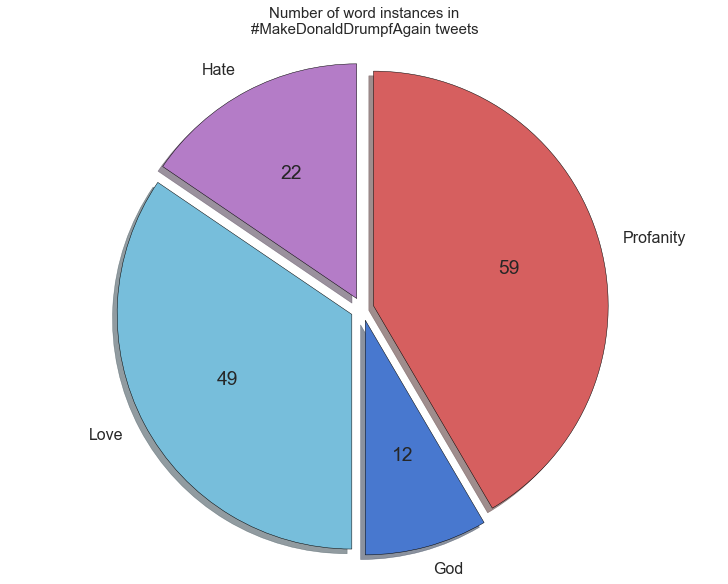

In [260]:
# The slices will be ordered and plotted counter-clockwise.
labels = list(custom_word_count.keys())
sizes = list(custom_word_count.values())
# l, s = [], []
# for a, b in enumerate(zip(labels, sizes)):
#     if b[0] != 'Profanity':
#         l.append(b[0]); s.append(b[1])
# labels, sizes = l, s
        
explode = (0.05, 0.05, 0.05, 0.05)
colors = sns.color_palette("muted", 10)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(p=pct,v=val)
    return my_autopct

plt.title('Number of word instances in\n#MakeDonaldDrumpfAgain tweets', y=1.05, fontsize=15)
plt.pie(sizes, explode=explode, labels=labels, colors=[colors[i] for i in [3, 5, 6, 2]],
        autopct=make_autopct(sizes), shadow=True, startangle=90) #'%1.1f%%'
plt.axis('equal')
plt.savefig('figures/tweet_word_count.png', bbox_inches='tight', dpi=144)

In [253]:
labels

['Asshole',
 'Shit',
 'Faggot',
 'Bitch',
 'Cunt',
 'Douchebag',
 'Fuck',
 'Motherfucker']

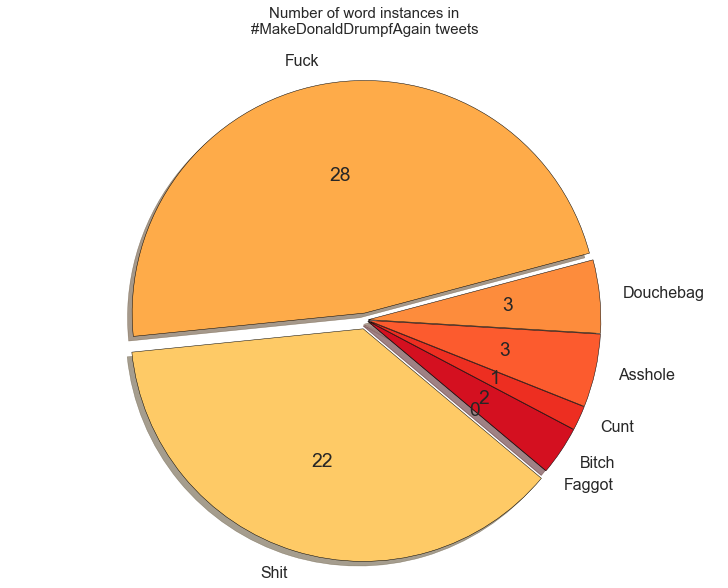

In [313]:
import random

# The slices will be ordered and plotted counter-clockwise.
labels = ['Faggot', 'Bitch', 'Cunt', 'Asshole',
          'Douchebag', 'Fuck', 'Shit']#, 'Motherfucker']
sizes = [profanity_details[key] for key in labels]
# l, s = [], []
# for a, b in enumerate(zip(labels, sizes)):
#     if b[0] != 'Profanity':
#         l.append(b[0]); s.append(b[1])
# labels, sizes = l, s
        
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.04)
colors = sns.color_palette("YlOrRd", 9)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(p=pct,v=val)
    return my_autopct

plt.title('Number of word instances in\n#MakeDonaldDrumpfAgain tweets', y=1.07, fontsize=15)
plt.pie(sizes, explode=explode, labels=labels, colors=colors[::-1],#[colors[i] for i in (3, 2, 2, 3, 4, 5, 6, 7)],
        autopct=make_autopct(sizes), shadow=True, startangle=320) #'%1.1f%%'
plt.axis('equal');
plt.savefig('figures/tweet_word_count_profane.png', bbox_inches='tight', dpi=144)

#### Debugging environment

In [ ]:
''' 'Mini' environment for debugging! '''
if False:
    tweet_files = list(glob.iglob('drumpf_tweets/#make'+'*'))
    mini_f = open(tweet_files[0], 'r')
    lines = mini_f.readlines()

    # 272 894 7242
    mini_tweet = json.loads(lines[894])
    mini_tweet['created_at']
    #mini_df = pd.DataFrame({'created_at': mini_tweet['created_at']})

    drumpf_dataframe.loc[894, 'created_at']

#### End debugging environment